In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create your connection.
conn = sqlite3.connect('../scraping-data/database/myDB.db')
df  = pd.read_sql_query('SELECT * FROM games', conn)
# df_copy = df.copy()   


# Data Cleaning

In [2]:
# [drop-> 'Mini', 'Dungeons', 'Games', 'Warhammer', ' Word'
#Steam -> Steam Machine
# 'trading', ]

df = df.drop_duplicates(subset=['tag', 'price', 'name', 'release'])
to_drop = ['Mini', 'Dungeons', 'Games', 'Warhammer', ' Word']
for i in to_drop:
    df.drop(df[df['tag'] == i].index, inplace=True)

df['tag'] == df['tag'].replace({'Steam': 'Steam Machine'})

df1 = df.loc[
        (
        (df['tag'] == 'Trading') |   
        (df['tag'] == 'Trading Card Game')
)]

df1 = df1.drop_duplicates(subset=['name', 'type', 'release'], keep='last')

to_drop2 = ['Trading', 'Trading Card Game']
for j in to_drop2:
    df.drop(df[df['tag']== j].index, inplace=True)

df = pd.concat([df, df1])


In [3]:
#convert ['peak', 'online', 'follows'] to int type
for i in ['peak', 'online', 'follows']:
    df[i] = df[i].str.replace(',', '')
    df[i].replace({'': np.nan, '—': np.nan}, inplace=True)
    df[i] = df[i].astype('Int64')
    df[i].fillna(0, inplace=True)

df['release'].replace({'—': np.nan}, inplace=True)

#fill all missing value with Nov 199 to avoid converting problems
df['release'].fillna('Nov 1900', inplace=True)

# #while i was trying to convert this column i occured a funny release date 
# Note: delete df.drop(df[df['name'] == 'CITRON WORLD FORWARD:ZERO'].index, inplace=True) # <- this game set to release in 4444-Apr lol
df['release'] = pd.to_datetime(df['release'], format='%b %Y', errors='coerce').dt.to_period('M')
df.dropna(subset=['release'], inplace=True)


In [4]:
#try df[['rating', 'price']]
to_replace = ['rating', 'price']
for i in to_replace:
    df[i].replace({
        '—': ''
    }, inplace=True)
    
df['rating'] = pd.to_numeric(df['rating'].str.replace('%', ''))

df['price'] = pd.to_numeric(df['price'].str.replace('$', ''))
df['price'].fillna(0, inplace=True)
df['free'] = df['price'].apply(lambda x: 'free' if x == 0.00 else 'paid')

/tmp/ipykernel_3519/2166327822.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = pd.to_numeric(df['price'].str.replace('$', ''))


In [5]:
df.head(5)

,tag,name,type,price,rating,release,follows,online,peak,free
0,Archery,Arrow a Row,Game,0.00,94.50,2023-08,2689,347,9404,free
1,Archery,Northern Journey,Game,11.99,92.93,2021-08,3793,3,153,paid
2,Archery,The Lab,Game,0.00,91.75,2016-04,26426,18,927,free
3,Archery,TowerFall Ascension,Game,7.99,91.03,2014-03,17007,3,355,paid
4,Archery,Enderal: Forgotten Stories (Special Edition),Game,0.00,90.09,2021-03,21863,267,2428,free


In [6]:
df1 = df.drop_duplicates(subset=['name', 'type', 'release'])
df1.shape

(150733, 10)

In [7]:
df1.sample(10)

,tag,name,type,price,rating,release,follows,online,peak,free
42029,Twin Stick Shooter,Abyssal Survivors,Game,0.00,NaN,1900-11,8,0,0,free
1245370,Massively Multiplayer,LURE: LITE,DLC,0.00,NaN,2020-12,0,0,0,free
186972,Dark,Seven Bullets Horror 7発の弾丸ホラー,Game,1.99,55.69,2024-02,13,0,2,paid
107828,Design & Illustration,Ecchi Beauties - 18+ Adult Only Content,DLC,0.00,59.42,2022-11,0,0,0,free
331245,Free to Play,Idle Champions - Black Cat Familiar,DLC,0.00,62.51,2018-09,0,0,0,free
743950,Sports,Club Manager 2016 - Upgrade to Club Manager 2017,DLC,14.99,42.61,2017-03,0,0,0,paid
132308,Female Protagonist,Casting Whispers,Game,0.00,NaN,1900-11,41,0,0,free
742835,Sports,ToaZZle,Game,4.99,56.83,2018-03,37,0,3,paid
55191,Gun Customization,Titan Survival,Game,0.00,NaN,1900-11,9,0,0,free
194089,Indie,Nimble Quest,Game,4.99,85.07,2013-12,690,1,321,paid


### Prices analysis 

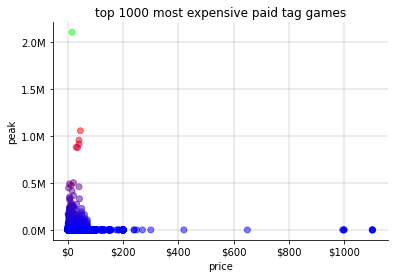

In [8]:
import matplotlib.cm as cm
#top 1000 most expensive paid tag games 
fig, ax = plt.subplots()
top_paid_games = df1.loc[df1['free'] == 'paid', ['tag',  'name', 'price', 'peak', 'free']
                        ].sort_values(by=['price'], ascending=False )
ax.scatter(top_paid_games['price'], top_paid_games['peak'], alpha=0.5, c=top_paid_games['peak'], cmap=cm.brg)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-6:.1f}M'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x)}'))
ax.set(title='top 1000 most expensive paid tag games',
        xlabel='price',
        ylabel='peak')
# plt.setp(ax.get_xticklabels(), rotation = 30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='black', linestyle='-', linewidth=0.30, alpha=0.5)



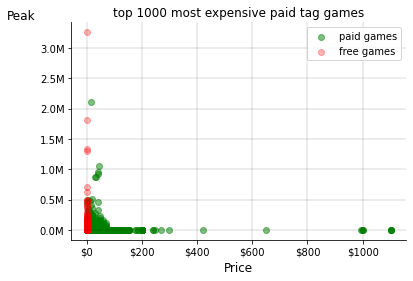

In [32]:
#comparing free and paid games based on the most played games in each
top_free_games = df1.loc[df1['free'] == 'free', ['tag',  'name', 'price', 'peak', 'free']]
fig, ax = plt.subplots()
ax.scatter(top_paid_games['price'], top_paid_games['peak'], c='g', alpha=0.5, label='paid games')
ax.scatter(top_free_games['price'], top_free_games['peak'], c='r', alpha=0.3, label='free games')
ax.grid(color='black', linestyle='-', linewidth=0.30, alpha=0.5)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-6:.1f}M'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x)}'))
fonts = {
        'fontsize': 12, 
        'fontweight': 550, 
        'color': 'black'
        }
ax.set(title='top 1000 most expensive paid tag games')
ax.set_ylabel(ylabel='Peak', rotation=0, loc='top', fontdict=fonts)
ax.set_xlabel(xlabel='Price', loc='center', fontdict=fonts)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')



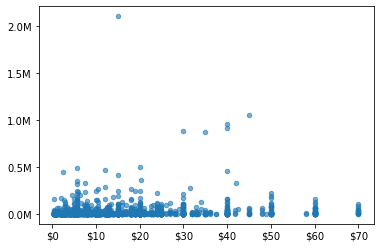

In [10]:
#top 1000 played paid games 
fig, ax = plt.subplots()
best_paid = df1.loc[df1['free'] == 'paid', ['tag',  'name', 'price', 'peak']
                    ].sort_values('peak', ascending=False).head(2000)
ax.scatter(best_paid['price'], best_paid['peak'], s=20, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-6:.1f}M'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x)}'))


In [11]:
best_paid.tail(5)

,tag,name,price,peak
493078,Bullet Hell,Spikit,0.45,2771
166055,Card Game,Heretic's Fork,5.79,2769
11382,Soundtrack,EZ2ON REBOOT : R,20.99,2768
129230,Female Protagonist,Chronicles of the Witches and Warlocks,4.99,2767
21130,Great Soundtrack,Quake II,5.99,2766
